<a href="https://colab.research.google.com/github/yuliiabosher/Fiber-optic-project/blob/statistical_analysis/ColabNotebooks/PostcodeLevelFibreDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fibre Project Data Analysis Notebook

**This notebook combines a number of different data sources into a dataframe that can be used for analysis.  At the moment it merges together data from the ONS and OFCOM, and provides some basic visuals regarding the different coverage in Urban and Rural areas.  The plan is also to include population data into this.**

## Section 1: Read the datafiles, clean and combine the data to allow analysis

### 1.1 Import the appropriate libraries to read CSV files into pandas dataframes

In [ ]:
import pandas as pd
import os.path
import glob
import errno

### 1.2 Mount your google drive to allow access to data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.3 Read the data files - location of the files should be updated based on your environment

* ONS Postcode data file available from https://geoportal.statistics.gov.uk/datasets/ons::ons-postcode-directory-february-2024-for-the-uk/about
* OFCOM Connected Nations Fixed Coverage Postcode Unit Data files available from https://www.ofcom.org.uk/phones-and-broadband/coverage-and-speeds/connected-nations-update-spring-2024/
* OFCOM Connected Nations Fixed Coverage Parliamentary Constiuency Unit Data files available from https://www.ofcom.org.uk/phones-and-broadband/coverage-and-speeds/connected-nations-update-spring-2024/
* ONS nomis output area population data from https://www.nomisweb.co.uk/census/2011/qs102uk

This code will check the files/directories exist in the specified locations, and read in the data from each source to a dataframe.  The shape of each dataframe is provided.

In [ ]:
#############
# ONS Postcode data file available from https://geoportal.statistics.gov.uk/datasets/ons::ons-postcode-directory-february-2024-for-the-uk/about
# This path should be set to the location of the ONSPD_FEB_2024_UK.csv file
#############
filePostCodeData = "/content/drive/MyDrive/ONSPD_FEB_2024_UK/Data/ONSPD_FEB_2024_UK.csv"

#############
# OFCOM Connected Nations Fixed Coverage Postcode Unit Data files available from https://www.ofcom.org.uk/phones-and-broadband/coverage-and-speeds/connected-nations-update-spring-2024/
# This path should be set to the top level folder containing multiple postcode level CSV files
#############
dirPostCodeBroadbandData = "/content/drive/MyDrive/202401_fixed_postcode_coverage_r01/postcode_files"

#############
# OFCOM Connected Nations Fixed Coverage Parliamentary Constiuency Unit Data files available from https://www.ofcom.org.uk/phones-and-broadband/coverage-and-speeds/connected-nations-update-spring-2024/
# This path should be set to the location of the 202401_fixed_pcon_coverage_r01.csv file
#############
filePConBroadbandData = "//content/drive/MyDrive/202401_fixed_pcon_coverage_r01/202401_fixed_pcon_coverage_r01.csv"

#############
# ONS nomis output area population data from https://www.nomisweb.co.uk/census/2011/qs102uk
# This path should be set to the location of a top level folder containing 12 files downloaded from the above link: 11 output areas files for the UK, and 1 small area file for Northern Ireland
#############
dirCensusPopulationData="/content/drive/MyDrive/2011_census_output_areas"


#############
# Check we can find the files/directories required, and read the raw data files into 4 pandas dataframes
#############
if os.path.exists(filePostCodeData) :
    print("Reading ONS Postcode data.....")
    dfPostCode = pd.read_csv(filePostCodeData,low_memory=False)
else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filePostCodeData)
print("ONS Postcode data shape:", dfPostCode.shape)

if os.path.exists(dirPostCodeBroadbandData) :
    print("Reading Connected Nations Postcode level fixed broadband information.....")
    all_files = glob.glob(os.path.join(dirPostCodeBroadbandData, "*.csv"))
    dfPostCodeBroadband = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), dirPostCodeBroadbandData)
print("Connected Nations Postcode level fixed broadband data shape:", dfPostCodeBroadband.shape)

if os.path.exists(filePConBroadbandData) :
    print("Reading Connected Nations Parliamentary Constituency level fixed broadband coverage information.....")
    dfPCon = pd.read_csv(filePConBroadbandData,low_memory=False, encoding='latin-1')
else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filePConBroadbandData)
print("Connected Nations Parliamentary Constituency level fixed broadband data shape:", dfPCon.shape)

if os.path.exists(dirCensusPopulationData) :
    print("Reading Census Population Data.....")
    all_files = glob.glob(os.path.join(dirCensusPopulationData, "*.csv"))
    dfCensusPopulation = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), dirCensusPopulationData)
print("Census population data by output area data shape:", dfCensusPopulation.shape)


Reading ONS Postcode data.....
ONS Postcode data shape: (2700777, 53)
Reading Connected Nations Postcode level fixed broadband information.....
Connected Nations Postcode level fixed broadband data shape: (1773144, 20)
Reading Connected Nations Parliamentary Constituency level fixed broadband coverage information.....
Connected Nations Parliamentary Constituency level fixed broadband data shape: (650, 40)
Reading Census Population Data.....
Census population data by output area data shape: (232296, 6)


### 1.4 Create a dataframe based on ONS data
This section retrieves live postcodes from the ONS dataset, along with their parliamentary constituency, country, the 2001 Census urban/rural indicator.  (Note: 2011 Census urban/rural indicator was also available but not for Northern Ireland, so I have selected the 2001 indicator instead), the latitude and longitude for the postcode, and the 2011 census output area.  


In [ ]:
#############
# Select the appropriate data from the ONS postcode file
# - Select relevant columns for analysis
# - Remove postcodes that are not live
# - Remove those that are not associated with a parliamentary constituency
# - Show the top of the resulting data and the shape of the dataframe
#############
# - Select relevant columns for analysis
# These columns look useful, based on the ONSßPD Record Specification documented in the ONSPD User Guide
onsPostCodeDataColumns = ['pcds','pcon','doterm','ctry','ur01ind','lat','long','oa11']
dfONSPostCodeData=dfPostCode[onsPostCodeDataColumns]
# - Remove  postcodes that are not live
# Rows where doterm is null are live postcodes: after that we can drop the doterm column as it's not useful to us
dfLiveONSPostCodeData = dfONSPostCodeData.loc[dfONSPostCodeData['doterm'].isnull()]
dfLiveONSPostCodeData = dfLiveONSPostCodeData.drop('doterm', axis=1)
# - Remove postcodes that are not associated with a parliamentary constituency
dfLiveONSPostCodePconData = dfLiveONSPostCodeData.loc[dfLiveONSPostCodeData['pcon'].notnull()]
# - Show the top of the resulting data and the shape of the dataframe
print("ONS Live postcodes with parliamentary constituency:")
display(dfLiveONSPostCodePconData.head())
print(dfLiveONSPostCodePconData.shape)

ONS Live postcodes with parliamentary constituency:


,pcds,pcon,ctry,ur01ind,lat,long,oa11
2656,AB10 1AB,S14000001,S92000003,1,57.149606,-2.096916,S00090540
2658,AB10 1AF,S14000001,S92000003,1,57.149590,-2.096923,S00090540
2659,AB10 1AG,S14000001,S92000003,1,57.149051,-2.097004,S00090540
2660,AB10 1AH,S14000001,S92000003,1,57.149590,-2.096923,S00090540
2662,AB10 1AL,S14000001,S92000003,1,57.150058,-2.095916,S00090540


(1797629, 7)


### 1.5 Create a dataframe from the OFCOM Conected Nations Postcode Data appropriate for joining to other data sources
This section creates a dataframe based on the OFCOM Connected Nations postcode data including selected columns indicating the availability of broadband of different speeds

In [ ]:
#############
# Select the appropriate data from the OFCOM Connected Nations postcode file
# - Select relevant columns for analysis
# - Rename the poscode column to align with ONS postcode data column
# - Show the top of the resulting data and the shape of the dataframe
#############
ofcomPostCodeDataColumns=['postcode_space','% of premises with 30<300Mbit/s download speed',
       '% of premises with >=300Mbit/s download speed',
       '% of premises with 0<2Mbit/s download speed',
       '% of premises with 2<5Mbit/s download speed',
       '% of premises with 5<10Mbit/s download speed',
       '% of premises with 10<30Mbit/s download speed',
       'SFBB availability (% premises)',
       'UFBB (100Mbit/s) availability (% premises)',
       'UFBB availability (% premises)',
       '% of premises unable to receive 2Mbit/s',
       '% of premises unable to receive 5Mbit/s',
       '% of premises unable to receive 10Mbit/s',
       '% of premises unable to receive 30Mbit/s',
       'Gigabit availability (% premises)']
dfOFCOMPostCodeDataBroadband=dfPostCodeBroadband[ofcomPostCodeDataColumns]
# - Rename the postcode column to align with ONS postcode data column name
dfOFCOMPostCodeDataBroadband=dfOFCOMPostCodeDataBroadband.rename(columns={"postcode_space": "pcds"})
# - Show the top of the resulting data and the shape of the dataframe
print("OFCOM Postcode Broadband data:")
display(dfOFCOMPostCodeDataBroadband.head())
print(dfOFCOMPostCodeDataBroadband.shape)

OFCOM Postcode Broadband data:


,pcds,% of premises with 30<300Mbit/s download speed,% of premises with >=300Mbit/s download speed,% of premises with 0<2Mbit/s download speed,% of premises with 2<5Mbit/s download speed,% of premises with 5<10Mbit/s download speed,% of premises with 10<30Mbit/s download speed,SFBB availability (% premises),UFBB (100Mbit/s) availability (% premises),UFBB availability (% premises),% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Gigabit availability (% premises)
0,AB10 6JD,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,100.0
1,AB10 7EB,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,100.0
2,AB11 6LP,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,100.0
3,AB11 6XA,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,100.0
4,AB12 3QD,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,100.0


(1773144, 15)


### 1.6 Create a dataframe from the OFCOM Conected Nations Parliamentary Constituency Data appropriate for joining to other data sources
Choose appropriate data from the OFCOM Connected Nations parliamentary consituency data, renaming the parliamentary constituency column to align with the ONS data

In [ ]:
#############
# Select the appropriate data from the OFCOM Connected Nations parliamentary constituency data
# - Select relevant columns for analysis
# - Rename columns to align with ONS data and prevent clashes with OFCOM postcode data
# - Show the top of the resulting data and the shape of the dataframe
#############
# - Select relevant columns for analysis
ofcomPConColumns = ['parl_const','Full Fibre availability (% premises)', 'Gigabit availability (% premises)']
dfOFCOMPConData=dfPCon[ofcomPConColumns]
# - Rename columns to align with ONS data and prevent clashes with OFCOM postcode data
dfOFCOMPConData=dfOFCOMPConData.rename(columns={'parl_const' : 'pcon', "Full Fibre availability (% premises)": "PCON Full Fibre availability (% premises)", "Gigabit availability (% premises)": "PCON Gigabit availability (% premises)"})
# - Show the top of the resulting data and the shape of the dataframe
print("Parliamentary Constituency Broadband data:")
display(dfOFCOMPConData.head())
print(dfOFCOMPConData.shape)

Parliamentary Constituency Broadband data:


,pcon,PCON Full Fibre availability (% premises),PCON Gigabit availability (% premises)
0,W07000049,39.9,83.0
1,W07000058,77.1,77.1
2,S14000001,88.8,88.8
3,S14000002,85.9,85.9
4,S14000003,41.6,85.9


(650, 3)


### 1.7 Create a datafrome from the ONS output area population data appropriate for joining to other data sources

Choose appropriate data and rename columns to align with other data sources

In [ ]:
#############
# Select the appropriate data from the OFCOM Connected Nations parliamentary constituency data
# - Select relevant columns for analysis
# - Rename columns to align with ONS data and prevent clashes with OFCOM postcode data
# - Show the top of the resulting data and the shape of the dataframe
#############
# - Select relevant columns for analysis
print(dfCensusPopulation.columns)
onsOAPopulationColumns = ['geography code','Area/Population Density: All usual residents; measures: Value']
dfOAPopulation=dfCensusPopulation[onsOAPopulationColumns]
# - Rename columns to align with ONS data and prevent clashes with OFCOM postcode data
dfOAPopulation=dfOAPopulation.rename(columns={'geography code' : 'oa11', "Area/Population Density: All usual residents; measures: Value": "oa11 Usual Resident Population Count"})
# - Show the top of the resulting data and the shape of the dataframe
print("Output Area Population data:")
display(dfOAPopulation.head())
print(dfOAPopulation.shape)

Index(['date', 'geography', 'geography code',
       'Area/Population Density: All usual residents; measures: Value',
       'Area/Population Density: Area Hectares; measures: Value',
       'Area/Population Density: Density (number of persons per hectare); measures: Value'],
      dtype='object')
Output Area Population data:


,oa11,oa11 Usual Resident Population Count
0,E00088544,362
1,E00088545,357
2,E00088546,418
3,E00088547,207
4,E00088552,122


(232296, 2)


### 1.8 Merge OFCOM and ONS Data
Merge together the data from the ONS and OFCOM. First merge the connected nations parliamentary data in to the ONS postcode data - I've used an inner join here so that only postcodes with a parliamentary constituency will be included in the resulting data. Then merge the OFCOM postcode data in - again an inner join is used, so the resulting data will only contain records that are both in the ONS postcode data and the Connected Nations postcode data.  

In [ ]:
#############
# Merge the data from ONS and OFCOM and store in a dataframe
# - Merge in OFCOM parliamentary constituency data
# - Merge in OFCOM postcode data
# - Merge in ONS Output Area population data
# - Show the top of the resulting data and the shape of the dataframe
#############
# - Merge in OFCOM parliamentary constituency data: use an inner join to remove postcodes that do not have a parliamentary constituency
dfMergedONSOFCOMData=pd.merge(dfLiveONSPostCodePconData, dfOFCOMPConData, on=['pcon'], how='inner')
# - Merge in OFCOM postcode data
dfMergedONSOFCOMData=pd.merge(dfMergedONSOFCOMData, dfOFCOMPostCodeDataBroadband, on=['pcds'], how='inner')
# - Merge in OA population data
dfMergedONSOFCOMData=pd.merge(dfMergedONSOFCOMData, dfOAPopulation, on=['oa11'], how='inner')
# - Show the top of the resulting data and the shape of the dataframe
print("Merged ONS/OFCOM Data:")
display(dfMergedONSOFCOMData.head())
print(dfMergedONSOFCOMData.shape)

Merged ONS/OFCOM Data:


,pcds,pcon,ctry,ur01ind,lat,long,oa11,PCON Full Fibre availability (% premises),PCON Gigabit availability (% premises),% of premises with 30<300Mbit/s download speed,...,% of premises with 10<30Mbit/s download speed,SFBB availability (% premises),UFBB (100Mbit/s) availability (% premises),UFBB availability (% premises),% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Gigabit availability (% premises),oa11 Usual Resident Population Count
0,AB10 1AF,S14000001,S92000003,1,57.149590,-2.096923,S00090540,88.8,88.8,100.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
1,AB10 1AG,S14000001,S92000003,1,57.149051,-2.097004,S00090540,88.8,88.8,100.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
2,AB10 1AH,S14000001,S92000003,1,57.149590,-2.096923,S00090540,88.8,88.8,100.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
3,AB10 1AL,S14000001,S92000003,1,57.150058,-2.095916,S00090540,88.8,88.8,100.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
4,AB10 1AN,S14000001,S92000003,1,57.149700,-2.094742,S00090540,88.8,88.8,80.0,...,20.0,80.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,93


(1759758, 24)


### 1.9 Include an estimate of the population per postcode based on the OA Usual Resident Population Count in an OA

This section adds a column "Estimated Usual Resident Population" to each postcode area.  It apportions the population count per OA across the number of postcodes assigned to that OA (so assumes all postcodes have the same number of residents).


In [ ]:
#############
# Merge the data from ONS and OFCOM and store in a dataframe
# - Create a dataframe that counts the number of postcodes in each Census 2011 output area
# - Define a custom function to estimate the usual resident population count per postcode based on averaging the OA resident population count
# - Apply the custom function create a new column "Estimated Usual Resident Population" and drop other unrequired columns
# - Merge in to existing data
# - Show the top of the resulting data and the shape of the dataframe
#############
# - Create a dataframe that counts the number of postcodes in each Census 2011 output area
dfApportionedPopulationInOA=dfMergedONSOFCOMData.groupby('oa11')[['oa11 Usual Resident Population Count']].value_counts()
dfApportionedPopulationInOA=dfApportionedPopulationInOA.to_frame().reset_index()
# - Define a custom function to estimate the usual resident population count per postcode based on averaging the OA resident population count
def estimate_population_per_postocde_availability(row):
    return row['oa11 Usual Resident Population Count']/row['count']
# - Apply the custom function create a new column "Estimated Usual Resident Population" and drop other unrequired columns
dfApportionedPopulationInOA['Estimated Usual Resident Population'] = dfApportionedPopulationInOA.apply(estimate_population_per_postocde_availability, axis=1)
dfApportionedPopulationInOA=dfApportionedPopulationInOA.drop(columns=['count','oa11 Usual Resident Population Count'])
# - Merge in to existing data
dfMergedONSOFCOMDataWithPopulation=pd.merge(dfMergedONSOFCOMData, dfApportionedPopulationInOA, on=['oa11'], how='inner')
# - Show the top of the resulting data and the shape of the dataframe
print("Merged ONS/OFCOM Data including estimate of usual resident population per postcode:")
display(dfMergedONSOFCOMDataWithPopulation.head())
print(dfMergedONSOFCOMDataWithPopulation.shape)



Merged ONS/OFCOM Data including estimate of usual resident population per postcode:


,pcds,pcon,ctry,ur01ind,lat,long,oa11,PCON Full Fibre availability (% premises),PCON Gigabit availability (% premises),% of premises with 30<300Mbit/s download speed,...,SFBB availability (% premises),UFBB (100Mbit/s) availability (% premises),UFBB availability (% premises),% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Gigabit availability (% premises),oa11 Usual Resident Population Count,Estimated Usual Resident Population
0,AB10 1AF,S14000001,S92000003,1,57.149590,-2.096923,S00090540,88.8,88.8,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875
1,AB10 1AG,S14000001,S92000003,1,57.149051,-2.097004,S00090540,88.8,88.8,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875
2,AB10 1AH,S14000001,S92000003,1,57.149590,-2.096923,S00090540,88.8,88.8,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875
3,AB10 1AL,S14000001,S92000003,1,57.150058,-2.095916,S00090540,88.8,88.8,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875
4,AB10 1AN,S14000001,S92000003,1,57.149700,-2.094742,S00090540,88.8,88.8,80.0,...,80.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,93,3.875


(1759758, 25)


### 1.10 Include Estimate of Full Fibre Coverage per postcode
This section uses the ratio of full fibre to gigabit availability at the parliametary constituency level to estimate the full fibre availability at postcode level. This is an estimate, as detailed data of full fibre coverage at postcode level is no longer available from OFCOM.

In [ ]:
#############
# This section estimates the full fibre connectivity per postcode based on the relationship between gigabit and full fibre coverage in the constituency
# - Define a custome function to combine columns
# - Apply the custom function create a new column "Estimated Full Fibre Availability (% premesis)
# - Show the top of the resulting data and the shape of the dataframe
#############
# Define a custom function to estimate full fibre availabliity per row
def estimate_fullfibre_availability(row):
    return row['PCON Full Fibre availability (% premises)']/row['PCON Gigabit availability (% premises)'] * row['Gigabit availability (% premises)']
# Apply the custom function create a new column "Estimated Full Fibre Availability (% premesis)
dfMergedONSOFCOMDataWithEstimate = dfMergedONSOFCOMDataWithPopulation.copy()
dfMergedONSOFCOMDataWithEstimate['Estimated Full Fibre availability (% premises)'] = dfMergedONSOFCOMDataWithEstimate.apply(estimate_fullfibre_availability, axis=1)

# Define a custom function to estimate gigabit availabliity
def estimate_poulation_fullfibre_availability(row):
    return row['Estimated Full Fibre availability (% premises)']/100 * row['Estimated Usual Resident Population']
# Apply the custom function create a new column "Estimated Full Fibre Availability (% premesis)
dfMergedONSOFCOMDataWithEstimate['Estimated Full Fibre availability (population)'] = dfMergedONSOFCOMDataWithEstimate.apply(estimate_poulation_fullfibre_availability, axis=1)

# - Show the top of the resulting data and the shape of the dataframe
print("Merged ONS/OFCOM Data including estimate of full fibre availability:")
display(dfMergedONSOFCOMDataWithEstimate.head())
print(dfMergedONSOFCOMDataWithEstimate.shape)


Merged ONS/OFCOM Data including estimate of full fibre availability:


,pcds,pcon,ctry,ur01ind,lat,long,oa11,PCON Full Fibre availability (% premises),PCON Gigabit availability (% premises),% of premises with 30<300Mbit/s download speed,...,UFBB availability (% premises),% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Gigabit availability (% premises),oa11 Usual Resident Population Count,Estimated Usual Resident Population,Estimated Full Fibre availability (% premises),Estimated Full Fibre availability (population)
0,AB10 1AF,S14000001,S92000003,1,57.149590,-2.096923,S00090540,88.8,88.8,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875,0.0,0.0
1,AB10 1AG,S14000001,S92000003,1,57.149051,-2.097004,S00090540,88.8,88.8,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875,0.0,0.0
2,AB10 1AH,S14000001,S92000003,1,57.149590,-2.096923,S00090540,88.8,88.8,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875,0.0,0.0
3,AB10 1AL,S14000001,S92000003,1,57.150058,-2.095916,S00090540,88.8,88.8,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93,3.875,0.0,0.0
4,AB10 1AN,S14000001,S92000003,1,57.149700,-2.094742,S00090540,88.8,88.8,80.0,...,0.0,0.0,0.0,0.0,20.0,0.0,93,3.875,0.0,0.0


(1759758, 27)


### 1.11 Classify each postcode as Urban or Rural
The following section includes a high level column "Urban/Rural" based on interpretting the 2001 Census urban/rural indicator. Not that the interpretation of "Rural" differs between Scotland, Northern Ireland and England/Wales. I have not changed the interpretation of any of the nations.

I have assumed the Channel Islands and Isle of Man would be considered Rural.


In [ ]:
#############
# This section adds an Urban/Rural classification column to the data based on interpreting the 2001 census urban/rural indicator
# - Define a custome function to combine columns
# - Apply the custom function create a new column "Urban/Rural"
# - Show the top of the resulting data and the shape of the dataframe
#############
# Define a custom function to classify a row as Urban/Rural
def classify_urban_rural(row):
    if row['ctry'] == 'E92000001' or row['ctry'] == 'W92000004' or row['ctry'] == 'S92000003':
        if int(row['ur01ind']) >=6:
            return "Rural"
        else:
            return "Urban"

    if row['ctry'] == 'N92000002':
        if row['ur01ind'] == 'F' or row['ur01ind'] == 'G' or row['ur01ind'] == 'H' :
            return "Rural"
        else:
            return "Urban"

    if row['ctry'] == 'L93000001' or row['ctry'] == 'M83000003':
        return "Rural"

    return None

# Apply the custom function create a new column "Urban/Rural"
dfCombinedONSOFCOMData = dfMergedONSOFCOMDataWithEstimate.copy()
dfCombinedONSOFCOMData['Urban/Rural'] = dfCombinedONSOFCOMData.apply(classify_urban_rural, axis=1)
# - Show the top of the resulting data and the shape of the dataframe
print("Data including Rural/Urban classification:")
display(dfCombinedONSOFCOMData.head(100))
print(dfCombinedONSOFCOMData.shape)

### 1.12 Validate the integrity of the resulting dataframe
This section checks the dataframe and counts the number of rows containing null values for each column.


In [ ]:
result = dfCombinedONSOFCOMData.isnull().sum()
print(result)

pcds                                              0
pcon                                              0
ctry                                              0
ur01ind                                           0
lat                                               0
long                                              0
oa11                                              0
PCON Full Fibre availability (% premises)         0
PCON Gigabit availability (% premises)            0
% of premises with 30<300Mbit/s download speed    0
% of premises with >=300Mbit/s download speed     0
% of premises with 0<2Mbit/s download speed       0
% of premises with 2<5Mbit/s download speed       0
% of premises with 5<10Mbit/s download speed      0
% of premises with 10<30Mbit/s download speed     0
SFBB availability (% premises)                    0
UFBB (100Mbit/s) availability (% premises)        0
UFBB availability (% premises)                    0
% of premises unable to receive 2Mbit/s           0
% of premise

## Section 2: Exploratory Analysis

### 2.1 This section imports libraries required for visualisation

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### 2.2 Compare the percentage of Urban/Rural premesis which cannot receive various broadband speeds

,% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Urban/Rural
Urban/Rural,,,,,
Rural,1.596332,3.733935,6.324031,15.091083,Rural
Urban,0.181312,0.496395,0.966233,3.416508,Urban


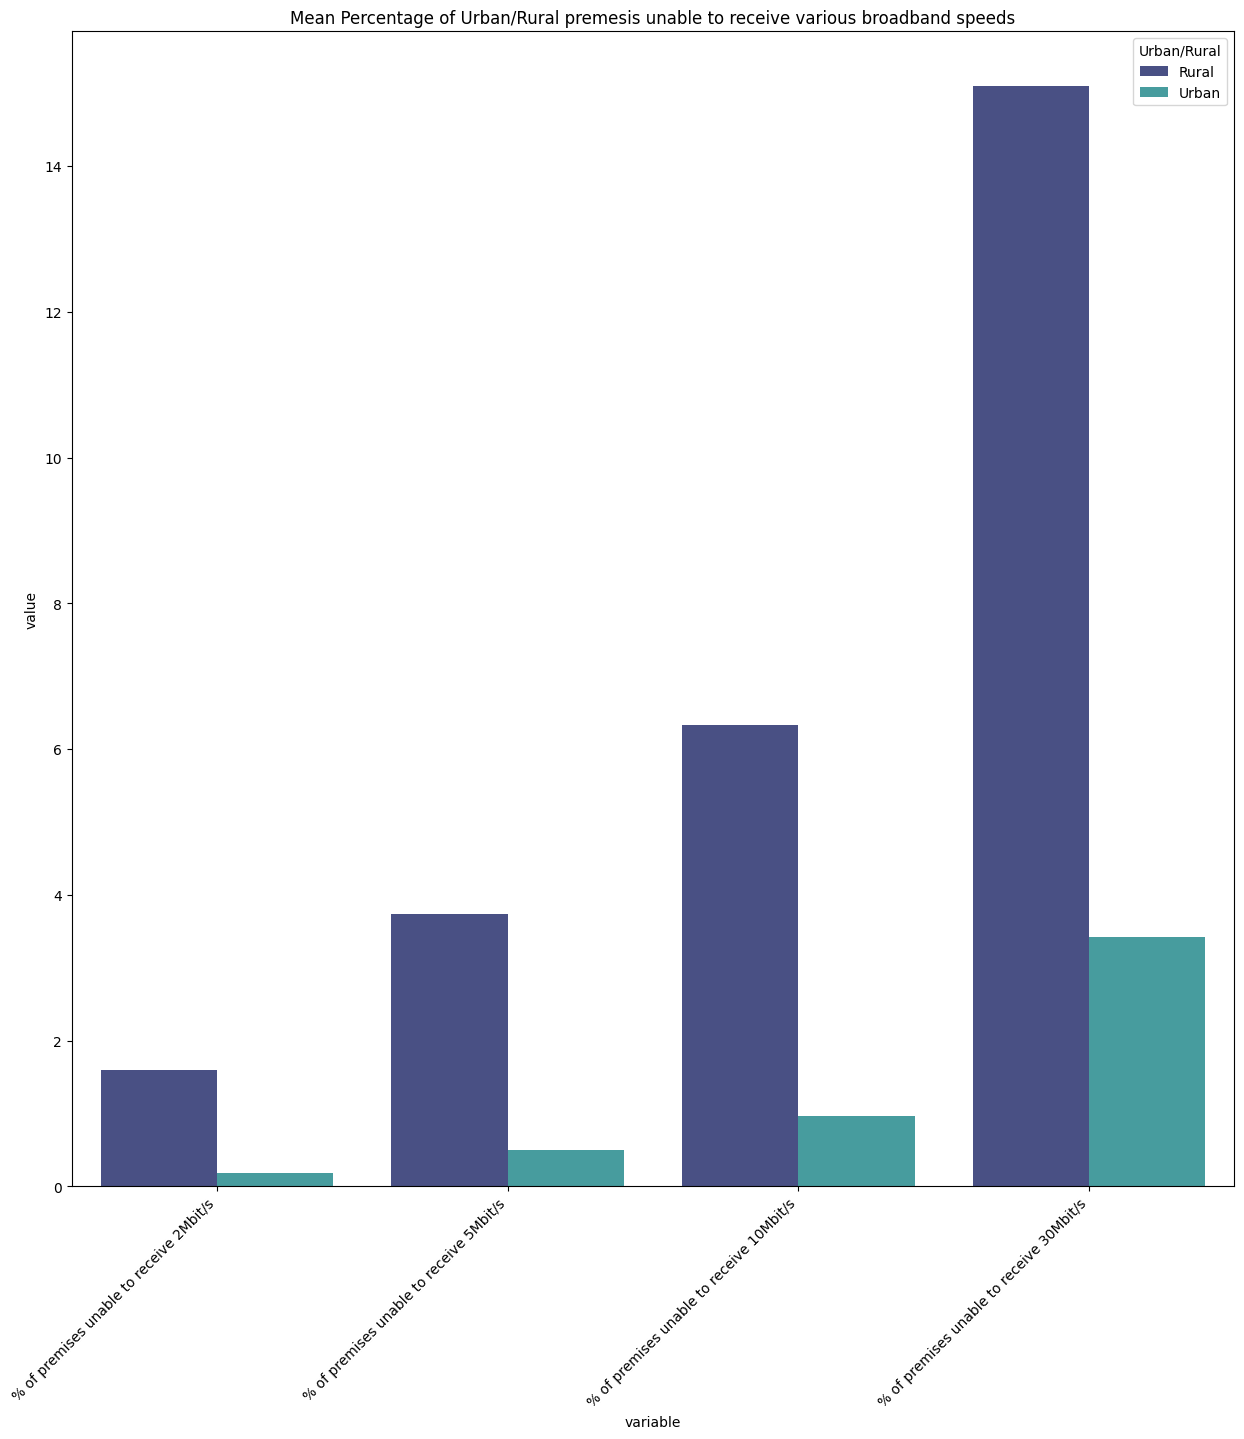

In [ ]:
#############
# Compare the percentage of Urban/Rural premesis which cannot receive various broadband speeds
# - Retrieve data to visualise premesis unable to receive broadband at various speeds.
# - Group the data by Urban/Rural classification, and calculate the mean values for each category across all Urban/Rural postcodes
# - Display mean values as a table and on a bar chart for comparison
#############
colums_unable_to_receive=['% of premises unable to receive 2Mbit/s',
       '% of premises unable to receive 5Mbit/s',
       '% of premises unable to receive 10Mbit/s',
       '% of premises unable to receive 30Mbit/s','Urban/Rural']
dfUnableToReceiveBroadband=dfCombinedONSOFCOMData[colums_unable_to_receive]
dfMeanUnableToReceiveBroadband=dfUnableToReceiveBroadband.groupby(["Urban/Rural"]).mean()
dfMeanUnableToReceiveBroadband["Urban/Rural"]=["Rural","Urban"]
display(dfMeanUnableToReceiveBroadband.head())
meltedData=dfMeanUnableToReceiveBroadband.melt(id_vars=["Urban/Rural"],value_vars=colums_unable_to_receive)
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(meltedData,x='variable',y='value',hue='Urban/Rural',palette=sns.color_palette("mako", 2),ax=ax)
output=sns.barplot().set_title("Mean Percentage of Urban/Rural premesis unable to receive various broadband speeds")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### 2.3 Compare the mean percentage of different download speeds between Urban/Rural postcodes

,% of premises with 0<2Mbit/s download speed,% of premises with 2<5Mbit/s download speed,% of premises with 5<10Mbit/s download speed,% of premises with 10<30Mbit/s download speed,% of premises with 30<300Mbit/s download speed,% of premises with >=300Mbit/s download speed
Urban/Rural,,,,,,
Rural,1.596332,2.137620,2.590125,8.767102,36.465700,47.99831
Urban,0.181312,0.315086,0.469838,2.450277,16.432767,79.87963


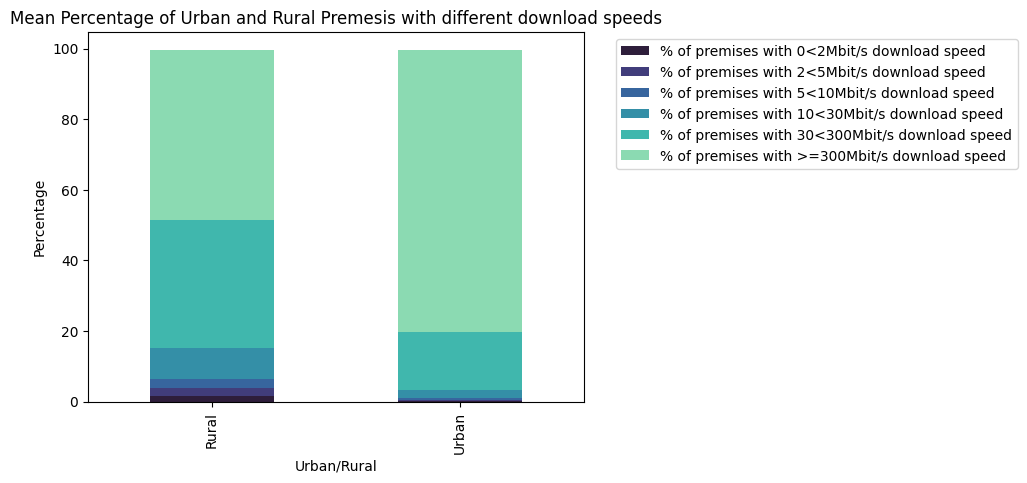

In [ ]:
#############
# Compare the percentage of Urban/Rural premesis with support for various speeds of broadband
# - Retrieve data to visualise premesis with support for various speeds of broadband
# - Group the data by Urban/Rural classification, and calculate the mean values for each category across all Urban/Rural postcodes
# - Display mean values in a table and on a stacked bar chart for comparison
#############
columns_mbits_supported=['% of premises with 0<2Mbit/s download speed',
       '% of premises with 2<5Mbit/s download speed',
       '% of premises with 5<10Mbit/s download speed',
       '% of premises with 10<30Mbit/s download speed',
       '% of premises with 30<300Mbit/s download speed',
       '% of premises with >=300Mbit/s download speed',
       'Urban/Rural']

dfMbitDownloadSpeed=dfCombinedONSOFCOMData[columns_mbits_supported]
dfMeanMbitDownloadSpeed=dfMbitDownloadSpeed.groupby(["Urban/Rural"]).mean()
display(dfMeanMbitDownloadSpeed)
colors=sns.color_palette('mako')[0:6]
dfMeanMbitDownloadSpeed.plot(kind='bar', stacked=True, color=colors)
# Add Title and Labels, and move the legend to the side
plt.title('Mean Percentage of Urban and Rural Premesis with different download speeds')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


### 2.4 Compare the availability of Fast broadband (including estimated full fibre availability) between Urban/Rural premesis

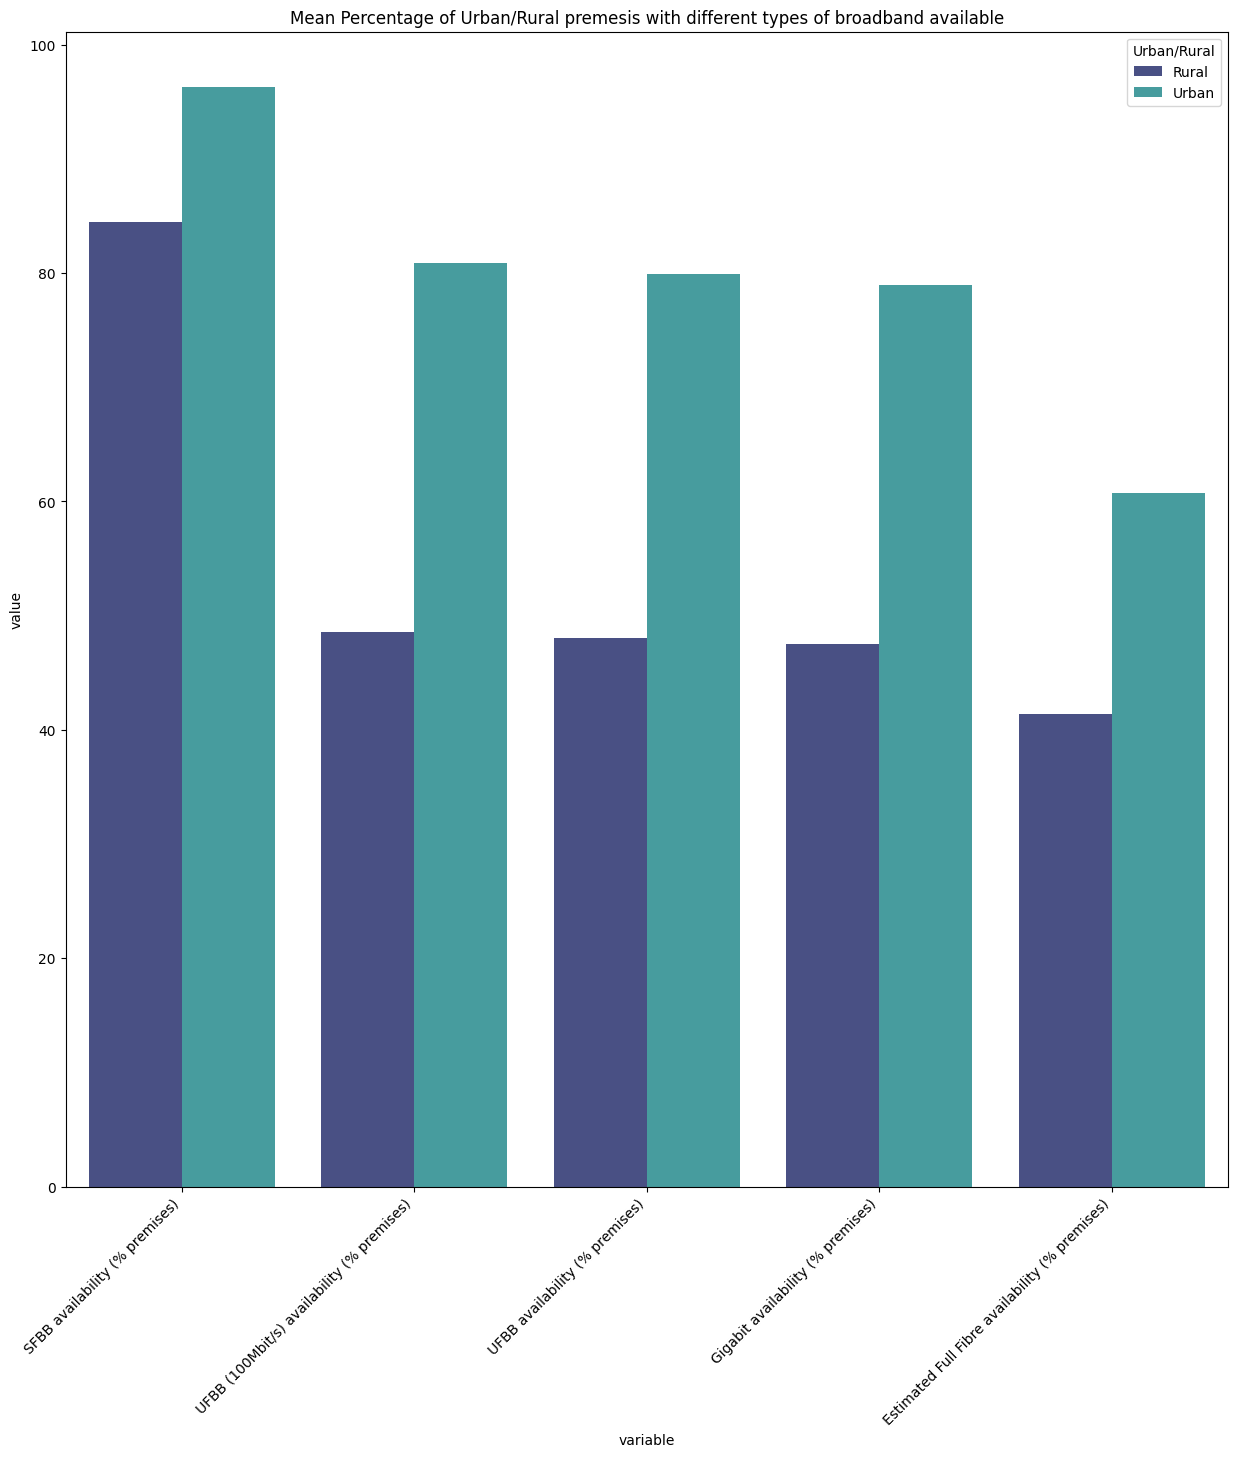

In [ ]:
#############
# Compare the percentage of Urban/Rural premesis with support for fast broadband including estiamted full fibre availabilirt
# - Retrieve data to visualise premesis with support for various speeds of broadband
# - Group the data by Urban/Rural classification, and calculate the mean values for each category across all Urban/Rural postcodes
# - Display mean values in a table and on a bar chart for comparison
#############
columns_fast_broadband=['SFBB availability (% premises)',
       'UFBB (100Mbit/s) availability (% premises)',
       'UFBB availability (% premises)',
       'Gigabit availability (% premises)',
       'Estimated Full Fibre availability (% premises)','Urban/Rural']

dfFastBroadbandData=dfCombinedONSOFCOMData[columns_fast_broadband]
dfMeanFastBroadbandData=dfFastBroadbandData.groupby(["Urban/Rural"]).mean()
dfMeanFastBroadbandData["Urban/Rural"]=["Rural","Urban"]
meltedData=dfMeanFastBroadbandData.melt(id_vars=["Urban/Rural"],value_vars=columns_fast_broadband)
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(meltedData,x='variable',y='value',hue='Urban/Rural',palette=sns.color_palette("mako", 2),ax=ax)
output=sns.barplot().set_title("Mean Percentage of Urban/Rural premesis with different types of broadband available")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

#### 2.6 What percentage of the population have no access to Full Fibre (estimated).  



<ipython-input-62-836110749937>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFullFibreBroadband['Population with no Full Fibre'] = dfFullFibreBroadband['Estimated Usual Resident Population']*dfFullFibreBroadband['Estimated Full Fibre availability (% premises)']


                 No Full Fibre   Full Fibre
Population Type                            
Total              6032.288433 -5932.288433
Rural              4424.169443 -4324.169443
Urban              6408.250711 -6308.250711


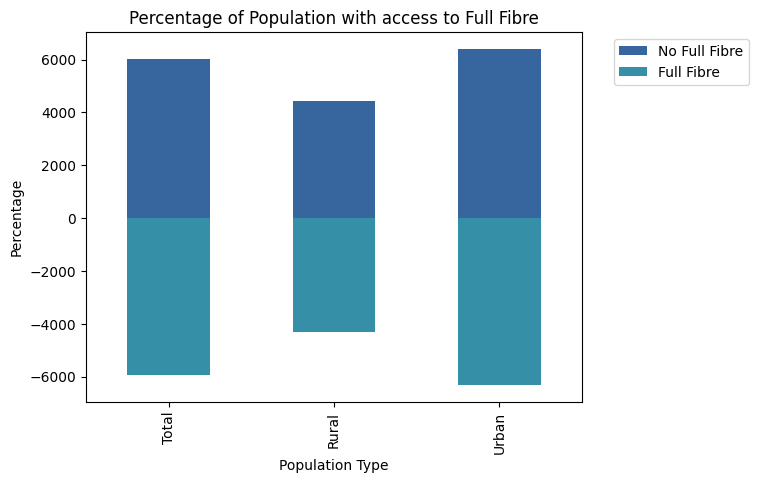

In [ ]:
#############
# What percentage of the population have no access to Full Fibre (split Urban/Rural)
# - Caculate the total population, and the split of the population living in Urban/Rural locations
# - Filter the data so only postcodes with no full fibre availability are included
# - Calculate the percentage of the population with no full fibre
#############
totalPopulation = dfCombinedONSOFCOMData['Estimated Usual Resident Population'].sum()
totalPopulationUrban = dfCombinedONSOFCOMData[dfCombinedONSOFCOMData['Urban/Rural'] == 'Urban']['Estimated Usual Resident Population'].sum()
totalPopulationRural = dfCombinedONSOFCOMData[dfCombinedONSOFCOMData['Urban/Rural'] == 'Rural']['Estimated Usual Resident Population'].sum()

columns_full_fibre_broadband=['pcds','ctry',
       'Estimated Usual Resident Population',
       'Estimated Full Fibre availability (% premises)',
       'Urban/Rural']

dfFullFibreBroadband=dfCombinedONSOFCOMData[columns_full_fibre_broadband]
dfFullFibreBroadband['Population with no Full Fibre'] = dfFullFibreBroadband['Estimated Usual Resident Population']*dfFullFibreBroadband['Estimated Full Fibre availability (% premises)']

#filter to include only postcodes with no Estimated Full Fibre availability
#dfNoFibreBroadbandData=dfCombinedONSOFCOMData[dfCombinedONSOFCOMData['Estimated Full Fibre availability (% premises)'] == 0.0]
#populationNoFibre = dfNoFibreBroadbandData['Estimated Usual Resident Population'].sum()
#populationNoFibreUrban = dfNoFibreBroadbandData[dfNoFibreBroadbandData['Urban/Rural'] == 'Urban']['Estimated Usual Resident Population'].sum()
#populationNoFibreRural = dfNoFibreBroadbandData[dfNoFibreBroadbandData['Urban/Rural'] == 'Rural']['Estimated Usual Resident Population'].sum()

populationNoFibre = dfFullFibreBroadband['Population with no Full Fibre'].sum()
populationNoFibreUrban = dfFullFibreBroadband[dfFullFibreBroadband['Urban/Rural'] == 'Urban']['Population with no Full Fibre'].sum()
populationNoFibreRural = dfFullFibreBroadband[dfFullFibreBroadband['Urban/Rural'] == 'Rural']['Population with no Full Fibre'].sum()

#Calculate the percentage of the population with no full fibre availability (estimated)
percentagePopulationNoFibre = populationNoFibre/totalPopulation * 100
percentageRuralPopulationNoFibre = populationNoFibreRural/totalPopulationRural *100
percentageUrbanPopulationNoFibre = populationNoFibreUrban/totalPopulationUrban *100


dfPercentagePopWithAccessToFullFibre={'No Full Fibre': [percentagePopulationNoFibre, percentageRuralPopulationNoFibre, percentageUrbanPopulationNoFibre],
                                      'Full Fibre': [100-percentagePopulationNoFibre, 100-percentageRuralPopulationNoFibre, 100-percentageUrbanPopulationNoFibre],
                                      'Population Type': ["Total", "Rural", "Urban"]}
dfPercentagePopWithAccessToFullFibre=pd.DataFrame(dfPercentagePopWithAccessToFullFibre)
dfPercentagePopWithAccessToFullFibre=dfPercentagePopWithAccessToFullFibre.set_index('Population Type')
print(dfPercentagePopWithAccessToFullFibre)
colors=sns.color_palette('mako')[2:4]
dfPercentagePopWithAccessToFullFibre.plot(kind='bar', stacked=True, color=colors)
# Add Title and Labels, and move the legend to the side
plt.title('Percentage of Population with access to Full Fibre')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


### 2.4 Compare the availability of Fast broadband (including estimated full fibre availability) across the 4 home nations

In [ ]:
#############
# Compare the percentage of Urban/Rural premesis with support for fast broadband including estiamted full fibre availabilirt
# - Retrieve data to visualise premesis with support for various speeds of broadband
# - Group the data by Urban/Rural classification, and calculate the mean values for each category across all Urban/Rural postcodes
# - Display mean values in a table and on a bar chart for comparison
#############
columns_fast_broadband_nations=['ctry',
       'SFBB availability (% premises)',
       'UFBB (100Mbit/s) availability (% premises)',
       'UFBB availability (% premises)',
       'Gigabit availability (% premises)',
       'Estimated Full Fibre availability (% premises)','Urban/Rural']

dfCountryFastBroadbandData=dfCombinedONSOFCOMData[columns_fast_broadband_nations]
dfMeanCountryFastBroadbandData=dfCountryFastBroadbandData.groupby(["ctry","Urban/Rural"]).mean()

display(dfMeanCountryFastBroadbandData)
dfMeanCountryFastBroadbandData["Urban/Rural"]=["Rural","Urban","Rural","Urban","Rural","Urban","Rural","Urban"]
dfMeanCountryFastBroadbandData["ctry"]=["England","England","Northern Ireland","Northern Ireland","Scotland","Scotland","Wales","Wales"]

display(dfMeanCountryFastBroadbandData)
meltedData=dfMeanCountryFastBroadbandData.melt(id_vars=["ctry","Urban/Rural"],value_vars=columns_fast_broadband)

meltedData["broadband"] = meltedData[['Urban/Rural', 'variable']].agg('-'.join, axis=1)
display(meltedData)
meltedData=meltedData.drop(columns=["Urban/Rural","variable"])
display(meltedData)

def show_graph(rural_urban_selection, data):
 # data=data[data["Urban/Rural"]==rural_urban_selection]
  #data=data.drop(columns=["Urban/Rural"])
  fig, ax = plt.subplots(figsize=(15, 15))
  sns.barplot(data,x='ctry',y='value',hue='broadband',palette=sns.color_palette("mako",2),ax=ax)
  ax.tick_params(axis='x', labelrotation=45)
  output=sns.barplot().set_title("Mean Percentage of premesis with different types of broadband available, with Urban/Rural classification")
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.show()
  ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha='right')

#show_graph("Rural",meltedData)
show_graph("Urban",meltedData)
